# **Задание Ultra pro**

Возьмите любую базу картинок (Mnist, Fashion Mnist, Cifar10 или собственную)
На картинках в случайных местах сделайте чёрные квадраты разного размера.
Обучите автокодировщик восстанавливать контент картинок, который скрыт чёрными квадратами.

*работать может неидеально

**это не совсем автокодировщик, так как у автокодировщика вход строго равен выходу, но архитектура очень близкая к автокодировщику

# Подключение библиотек

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Reshape, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image, ImageDraw
import random
import imageio
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Создание функций

In [ ]:
# Функция вывода изображения как картинок для Cifar10

def plotImages(xTrain, pred, shape=(32,32)):
  n = 10  # Кол-во картинок
  plt.figure(figsize=(21,7))  # Задаем фигуру и ее размер

  for i in range(n):
    index = np.random.randint(0, pred.shape[0])

    # Картинки из тестового набора
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xTrain[index])
    ax.set_title(f'{index}')
    # Скрываем выводы координатных осей x и y. 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Восстановленные картинки
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(pred[index])
    ax.set_title(f'{index}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
# Функция для расчета среднеквадратичной ошибки - mse
def getMSE(x1, x2):
  x1 = x1.flatten()
  x2 = x2.flatten()
  delta = x1 - x2
  return sum(delta**2) / len(delta)

In [ ]:
# Функция создания автокодировщика

def baseAutoencoder(shape=(32,32,3)):
  img_input = Input((shape))   # Входные размеры

  x = Conv2D(32, (3,3), padding='same', activation='relu')(img_input)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  z = MaxPooling2D()(x)   

  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation='relu')(z)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(shape[-1], (3,3), padding='same', activation='sigmoid')(x)

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

  return model

In [ ]:
# Функция создания автокодировщика Ver2 
def modelAutoencoderConv2D():
  img_input = Input((32,32,3))

  x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(img_input)    # Размер (16,16)
  x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)            # Размер (8,8)

  x = Flatten()(x)                     #  Одномерный вектор - размер 8*8*256
  x = Dense(256, activation='relu')(x) # добавляем полносвязный слой

  z = Dense(128, activation='relu')(x)
   
  x = Dense(256, activation='relu')(z)  # добавляем полносвязный слой

  # Переводим в 143360-мерное пространство(28*20*256)
  x = Dense(8*8*256, activation='relu')(x)
  
  x = Reshape((8,8,256))(x)
  x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)                       # Размер (16,16)
  x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)                       # Размер (32,32)
  x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) 

  model = Model(img_input, x) 
  model.compile(optimizer='adam', loss='mse')

  return model


In [ ]:
# Воспользуемся callback для лучшего обучения (изменения шага обучения)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
# Функция вывода изображения для базы Mnist (1 канал, черно-белое изображение)

def plotImagesMnist(xTrain, pred, shape=(28,28)):
  n = 10  # Кол-во картинок
  plt.figure(figsize=(21,7))  # Задаем фигуру и ее размер

  for i in range(n):
    index = np.random.randint(0, pred.shape[0])

    # Картинки из тестового набора
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xTrain[index].reshape(shape))
    plt.gray()
    ax.set_title(f'{index}')
    # Скрываем выводы координатных осей x и y. 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Восстановленные картинки
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(pred[index].reshape(shape))
    plt.gray()
    ax.set_title(f'{index}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
# Функция создания нейронной сети на свертке Conv2D для Mnist
def modelAutoencoderConv2DMnist():
  img_input = Input((28,28,1))

  x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(img_input)    # Размер (14,14)
  x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)            # Размер (7,7)

  x = Flatten()(x)                     #  Одномерный вектор - размер 8*8*256
  x = Dense(256, activation='relu')(x) # добавляем полносвязный слой

  z = Dense(128, activation='relu')(x)
   
  x = Dense(256, activation='relu')(z)  # добавляем полносвязный слой

  # Переводим в 143360-мерное пространство(7*7*256)
  x = Dense(7*7*256, activation='relu')(x)
  
  x = Reshape((7,7,256))(x)
  x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)                       # Размер (14,14)
  x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)                       # Размер (28,28)
  x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 

  model = Model(img_input, x) 
  model.compile(optimizer='adam', loss='mse')

  return model


# На базе Cifar- 10

In [ ]:
# Для начала загрузим базу cifar10
(xTrain, yTrain),(xTest, yTest) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
# Посмотрим на размерность получившихся массивов
print("xTrain: ", xTrain.shape)
print("xTest:  ", xTest.shape)


xTrain:  (50000, 32, 32, 3)
xTest:   (10000, 32, 32, 3)


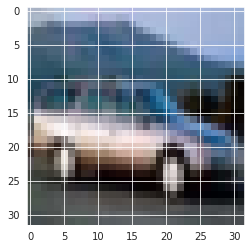

In [ ]:
# Пример одного изображения
plt.imshow(xTrain[4])
plt.show()

# На картинках в случайных местах сделайте чёрные квадраты разного размера

In [ ]:
# Выбираем размер квадрата от 5 до 10 пикселей. Если меньше 5 - то маленький, если больше 10 - то очень большой.
# В итоге будут квадраты 5x5, 6x6, 7x7, 8x8, 9х9, 10х10

In [ ]:
# Сделаем копию обучающей и тестовой выборок и в них будем добавлять черные квадраты на каждой картинке.

xTrain_squareBlack = xTrain.copy()
xTest_squareBlack = xTest.copy()

print(xTrain_squareBlack.shape)
print(xTest_squareBlack.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
# C помощью цикла пройдемся по всем картинкам
for i in range(0, xTrain.shape[0]):
  square_size = np.random.randint(5,11)           # Произвольно зададим границы квадрата от 5х5 до 10х10
  string = np.random.randint(0,22)                # Получим строку в которой будет начинаться квадрат. Так как максимальный размер квадрата может быть 10х10, то строка будет до 22
  columns = np.random.randint(0,22)               # Получим производный столбец

  for j in range(square_size+1):                  # C помощью цикла будет рисоваться квадрат (приравниваться к 0) на каждой тестовой картинке
    xTrain_squareBlack[i][string+j][columns: columns+square_size] = 0


In [ ]:
# Аналогично для тестовой выборки

for i in range(0, xTest.shape[0]):
  square_size = np.random.randint(5,11)           
  string = np.random.randint(0,22)               
  columns = np.random.randint(0,22)              

  for j in range(square_size+1):                 
    xTest_squareBlack[i][string+j][columns: columns+square_size] = 0

In [ ]:
# Как пример что в цикле происходит:
# x[7][8:16] = 0
# x[8][8:16] = 0 
# x[9][8:16] = 0 
# x[10][8:16] = 0 
# x[11][8:16] = 0 
# x[12][8:16] = 0 
# x[13][8:16] = 0 
# x[14][8:16] = 0 

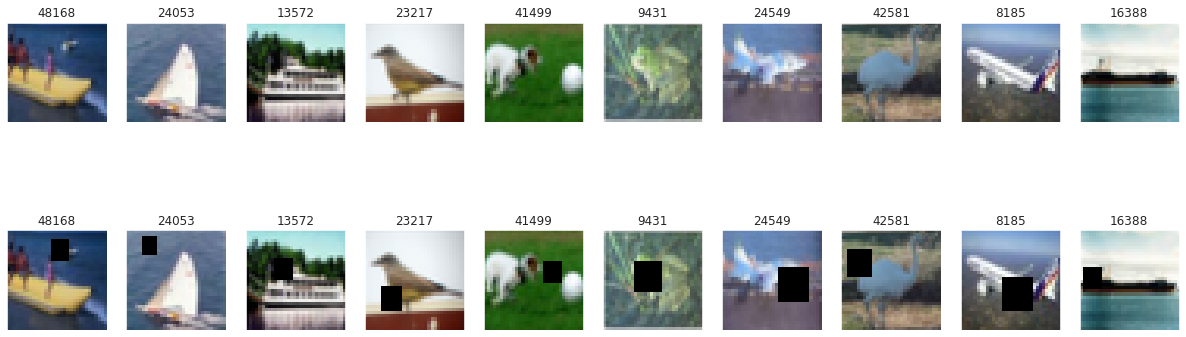

In [ ]:
# Посмотрим на результат.
# C помощью функции выведем изначальные картинки и картинки с произволдными черными квадратами
plotImages(xTrain, xTrain_squareBlack)

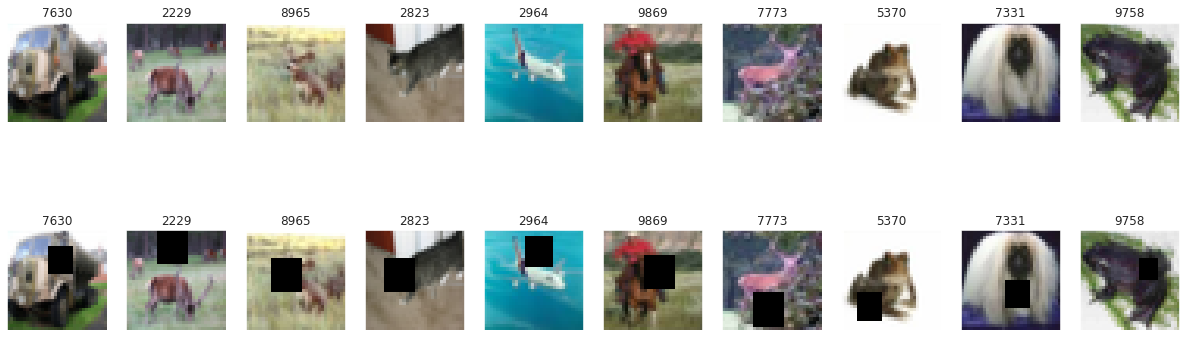

In [ ]:
# Тестовая выборка
plotImages(xTest, xTest_squareBlack)

# Нормализация

In [ ]:
# Нормализуем обучающую выборку без квадратов
xTrain = xTrain.astype('float32') / 255
xTrain.shape

(50000, 32, 32, 3)

In [ ]:
# Нормализуем обучающую выборку с черными квадратами
xTrain_squareBlack = xTrain_squareBlack.astype('float32') / 255
xTrain_squareBlack.shape

(50000, 32, 32, 3)

In [ ]:
# Нормализуем тестовую выборку без квадратов
xTest = xTest.astype('float32') / 255
xTest.shape

(10000, 32, 32, 3)

In [ ]:
# Нормализуем тестовую выборку с черными квадратами
xTest_squareBlack = xTest_squareBlack.astype('float32') / 255
xTest_squareBlack.shape

(10000, 32, 32, 3)

# Обучите автокодировщик восстанавливать контент картинок, который скрыт чёрными квадратами.

In [ ]:
# Создаем сеть
modelAutoCifar10 = baseAutoencoder()

## Модель сети

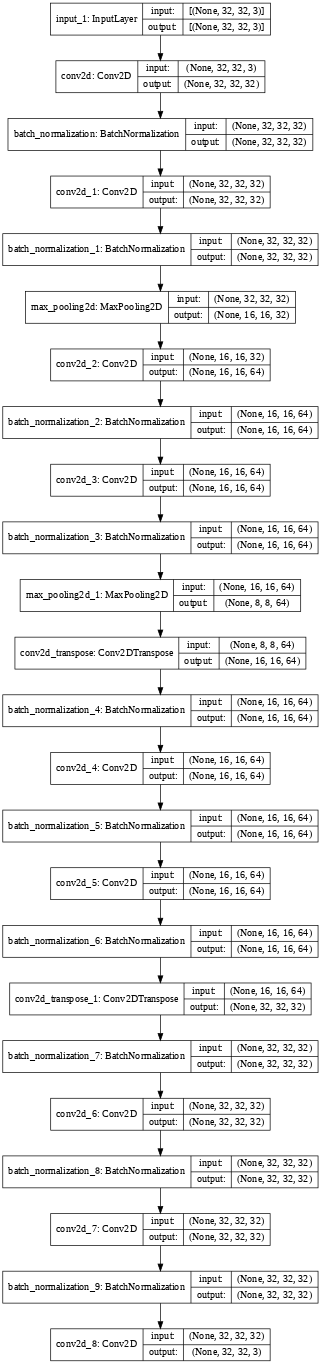

In [ ]:
plot_model(modelAutoCifar10, dpi=50, show_shapes=True)

## Обучение сети

In [ ]:
# На вход подаем зашумленное изображение, а на выходе чистое изображение(На обучающей и проверочной выборках)
historyCifar10 = modelAutoCifar10.fit(xTrain_squareBlack, xTrain, epochs=10, batch_size=1024, validation_data=(xTest_squareBlack, xTest))

Epoch 1/10
49/49 [==============================] - 57s 489ms/step - loss: 0.0690 - val_loss: 0.0632
Epoch 2/10
49/49 [==============================] - 21s 421ms/step - loss: 0.0255 - val_loss: 0.0622
Epoch 3/10
49/49 [==============================] - 21s 422ms/step - loss: 0.0177 - val_loss: 0.0592
Epoch 4/10
49/49 [==============================] - 21s 423ms/step - loss: 0.0146 - val_loss: 0.0542
Epoch 5/10
49/49 [==============================] - 21s 423ms/step - loss: 0.0128 - val_loss: 0.0467
Epoch 6/10
49/49 [==============================] - 21s 422ms/step - loss: 0.0116 - val_loss: 0.0374
Epoch 7/10
49/49 [==============================] - 21s 422ms/step - loss: 0.0107 - val_loss: 0.0288
Epoch 8/10
49/49 [==============================] - 21s 422ms/step - loss: 0.0100 - val_loss: 0.0217
Epoch 9/10
49/49 [==============================] - 21s 423ms/step - loss: 0.0095 - val_loss: 0.0179
Epoch 10/10
49/49 [==============================] - 21s 423ms/step - loss: 0.0090 - val_lo

In [ ]:
# Сохраним полученные веса
modelAutoCifar10.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoCifar10_UltraPro.h5')

## Проверка результатов

In [ ]:
# Получаем результат на обучающей выборке
predTrainCifar10 = modelAutoCifar10.predict(xTrain_squareBlack)
predTrainCifar10 = predTrainCifar10 * 255   # Перевод значений от 0 до 255
predTrainCifar10 = predTrainCifar10.astype('uint8')

In [ ]:
# Получаем результат работы на тестовой выборке
predTestCifar10 = modelAutoCifar10.predict(xTest_squareBlack)
predTestCifar10 = predTestCifar10 * 255

predTestCifar10 = predTestCifar10.astype('uint8')

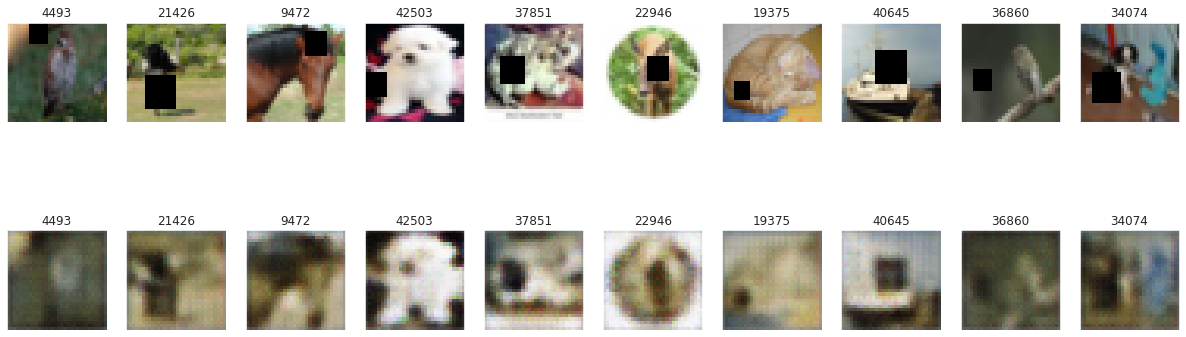

In [ ]:
# Результат на проверочной выборке
plotImages(xTrain_squareBlack, predTrainCifar10)

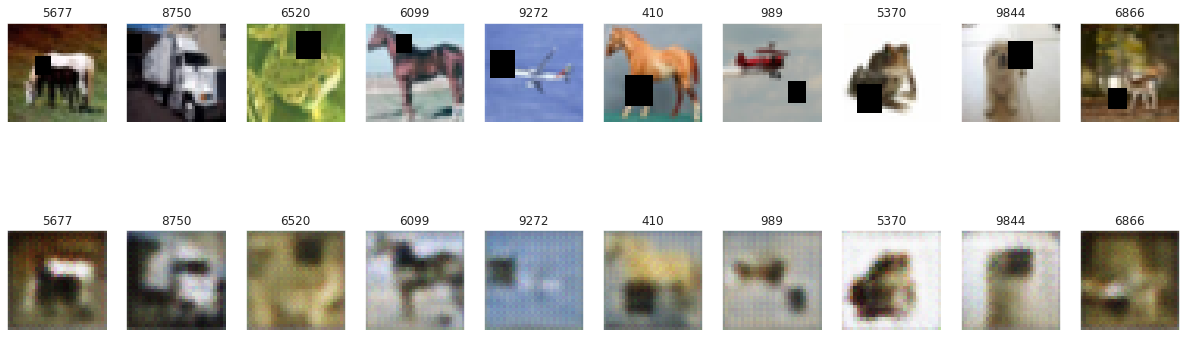

In [ ]:
# Результат на тестовой выборке
plotImages(xTest_squareBlack, predTestCifar10)

In [ ]:
# Cреднеквадратичная ошибка от правильной картинки и восстановленной (на обучающей и тестовой выборки)
err1 = [getMSE(xTrain[i], predTrainCifar10[i] / 255) for i in range(len(predTrainCifar10))]
err2 = [getMSE(xTest[i], predTestCifar10[i] /255) for i in range(len(predTestCifar10))]

In [ ]:
print("Средняя ошибка на обучающем наборе: ", sum(err1) / xTrain.shape[0])
print("Средняя ошибка на тестовом наборе: ", sum(err2) / xTest.shape[0])

Средняя ошибка на обучающем наборе:  0.015631566157011757
Средняя ошибка на тестовом наборе:  0.015726955514975986


## Дообучение сети

**Видно что результат не идеален. Поэтому попробуем загрузить ранее сохраненную модель и дообучить.**

In [ ]:
# Для загрузки весов
modelAutoCifar10.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoCifar10_UltraPro.h5')

In [ ]:
historyCifar10 = modelAutoCifar10.fit(xTrain_squareBlack, xTrain, epochs=50, batch_size=512, validation_data=(xTest_squareBlack, xTest))

Epoch 1/50
98/98 [==============================] - 24s 233ms/step - loss: 0.0085 - val_loss: 0.0127
Epoch 2/50
98/98 [==============================] - 21s 219ms/step - loss: 0.0079 - val_loss: 0.0091
Epoch 3/50
98/98 [==============================] - 21s 219ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 4/50
98/98 [==============================] - 21s 218ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 5/50
98/98 [==============================] - 21s 219ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 6/50
98/98 [==============================] - 21s 219ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 7/50
98/98 [==============================] - 21s 219ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 8/50
98/98 [==============================] - 21s 218ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 9/50
98/98 [==============================] - 21s 218ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 10/50
98/98 [==============================] - 21s 218ms/step - loss: 0.0056 - val_lo

In [ ]:
# Сохраним полученные веса
modelAutoCifar10.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoCifar10_UltraPro.h5')

## Проверка результатов

In [ ]:
# Получаем результат на обучающей выборке
predTrainCifar10 = modelAutoCifar10.predict(xTrain_squareBlack)
predTrainCifar10 = predTrainCifar10 * 255   # Перевод значений от 0 до 255
predTrainCifar10 = predTrainCifar10.astype('uint8')

In [ ]:
# Получаем результат работы на тестовой выборке
predTestCifar10 = modelAutoCifar10.predict(xTest_squareBlack)
predTestCifar10 = predTestCifar10 * 255
predTestCifar10 = predTestCifar10.astype('uint8')

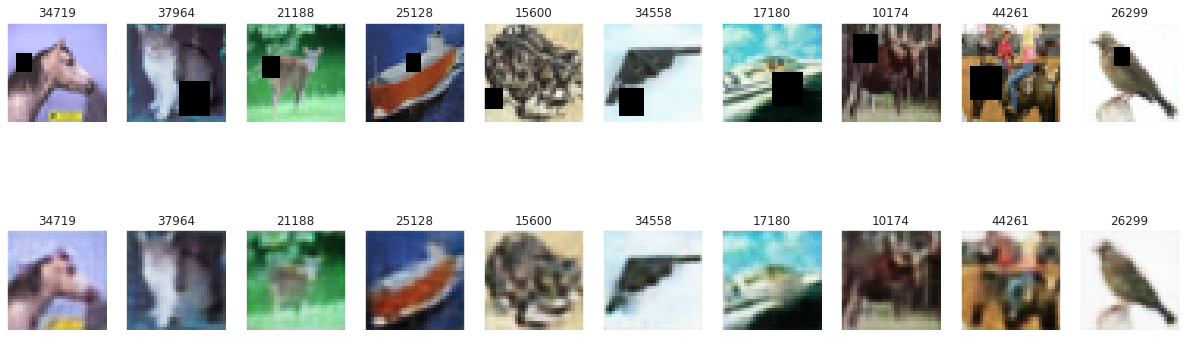

In [ ]:
# Результат на проверочной выборке
plotImages(xTrain_squareBlack, predTrainCifar10)

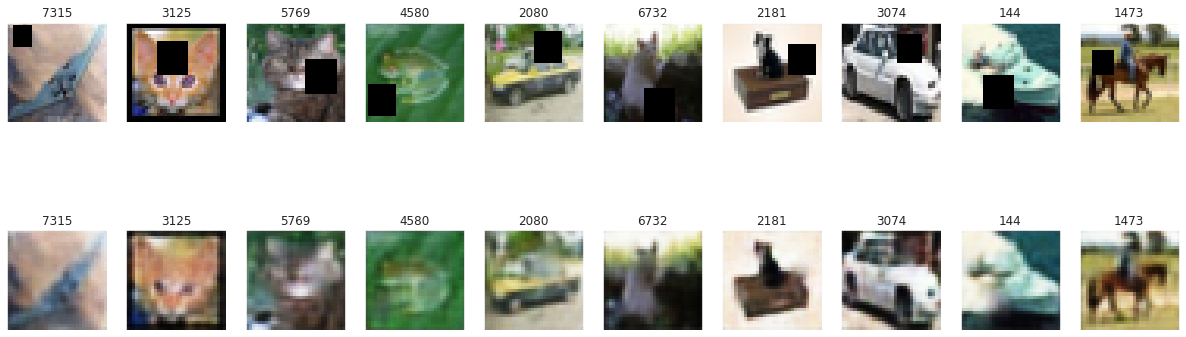

In [ ]:
# Результат на тестовой выборке
plotImages(xTest_squareBlack, predTestCifar10)

In [ ]:
# Cреднеквадратичная ошибка от правильной картинки и восстановленной (на обучающей и тестовой выборки)
err1 = [getMSE(xTrain[i], predTrainCifar10[i] / 255) for i in range(len(predTrainCifar10))]
err2 = [getMSE(xTest[i], predTestCifar10[i] /255) for i in range(len(predTestCifar10))]

In [ ]:
print("Средняя ошибка на обучающем наборе: ", sum(err1) / xTrain.shape[0])
print("Средняя ошибка на тестовом наборе: ", sum(err2) / xTest.shape[0])

Средняя ошибка на обучающем наборе:  0.0031272608529439106
Средняя ошибка на тестовом наборе:  0.0031577924591559858


# Вторая версия сети с  Conv2D

Попоробуем реализовать данную задачу с помощью другой модели нейронной сети используя сверточные слои

In [ ]:
# Создаем сеть
modelAutoCifar10Ver2 = modelAutoencoderConv2D()

## Модель сети

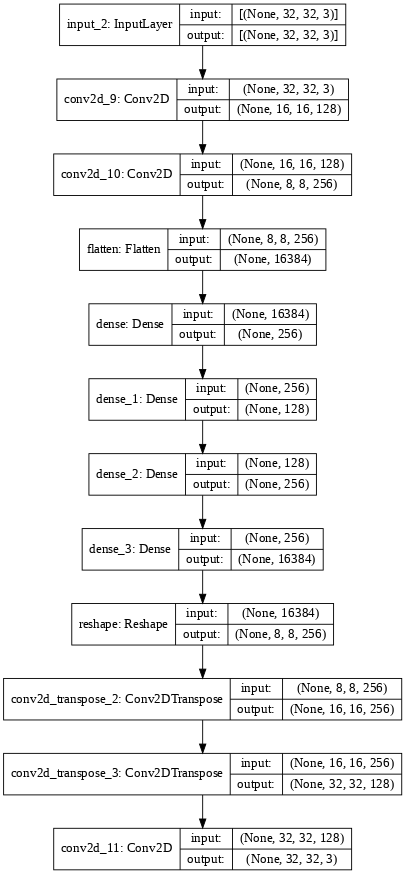

In [ ]:
plot_model(modelAutoCifar10Ver2, dpi=65, show_shapes=True)

## Обучение сети Conv2D 

In [ ]:
historyCifar10Ver2 = modelAutoCifar10Ver2.fit(xTrain_squareBlack, xTrain, epochs=10, batch_size=1024, validation_data=(xTest_squareBlack, xTest))

Epoch 1/10
49/49 [==============================] - 59s 1s/step - loss: 0.0555 - val_loss: 0.0380
Epoch 2/10
49/49 [==============================] - 46s 937ms/step - loss: 0.0325 - val_loss: 0.0280
Epoch 3/10
49/49 [==============================] - 46s 940ms/step - loss: 0.0253 - val_loss: 0.0232
Epoch 4/10
49/49 [==============================] - 46s 936ms/step - loss: 0.0217 - val_loss: 0.0195
Epoch 5/10
49/49 [==============================] - 46s 937ms/step - loss: 0.0185 - val_loss: 0.0174
Epoch 6/10
49/49 [==============================] - 46s 939ms/step - loss: 0.0169 - val_loss: 0.0161
Epoch 7/10
49/49 [==============================] - 46s 939ms/step - loss: 0.0155 - val_loss: 0.0150
Epoch 8/10
49/49 [==============================] - 46s 941ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 9/10
49/49 [==============================] - 46s 939ms/step - loss: 0.0138 - val_loss: 0.0133
Epoch 10/10
49/49 [==============================] - 46s 937ms/step - loss: 0.0136 - val_loss:

In [ ]:
# Сохраним полученные веса
modelAutoCifar10Ver2.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoCifar10Ver2_UltraPro.h5')

## Проверка результатов

In [ ]:
# Получаем результат на обучающей выборке
predTrainCifar10Ver2 = modelAutoCifar10Ver2.predict(xTrain_squareBlack)
predTrainCifar10Ver2 = predTrainCifar10Ver2 * 255   # Перевод значений от 0 до 255
predTrainCifar10Ver2 = predTrainCifar10Ver2.astype('uint8')

In [ ]:
# Получаем результат работы на тестовой выборке
predTestCifar10Ver2 = modelAutoCifar10Ver2.predict(xTest_squareBlack)
predTestCifar10Ver2 = predTestCifar10Ver2 * 255
predTestCifar10Ver2 = predTestCifar10Ver2.astype('uint8')

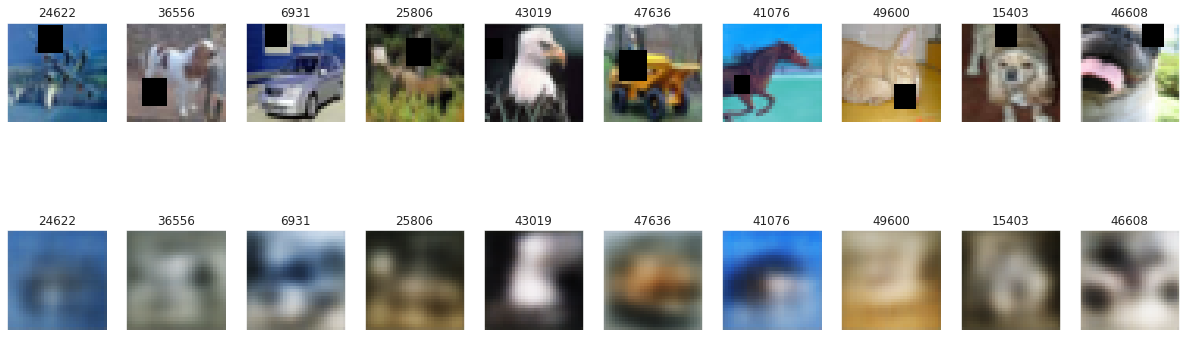

In [ ]:
# Результат на проверочной выборке
plotImages(xTrain_squareBlack, predTrainCifar10Ver2)

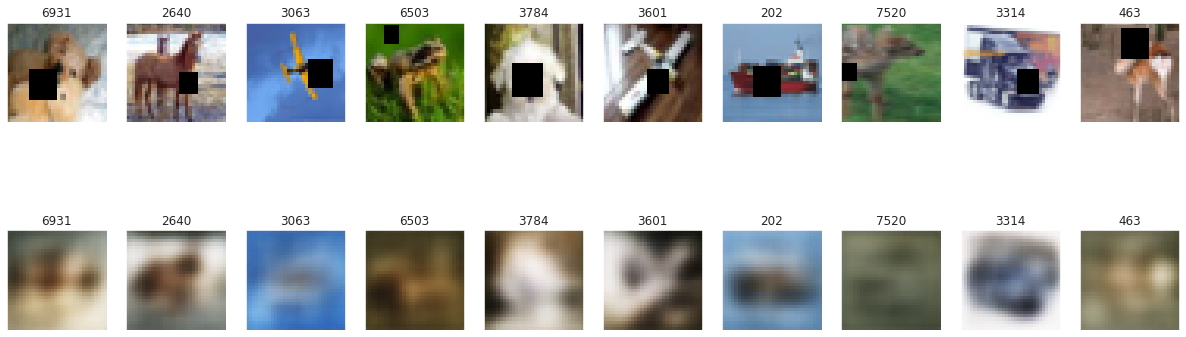

In [ ]:
# Результат на тестовой выборке
plotImages(xTest_squareBlack, predTestCifar10Ver2)

In [ ]:
# Cреднеквадратичная ошибка от правильной картинки и восстановленной (на обучающей и тестовой выборки)
err1 = [getMSE(xTrain[i], predTrainCifar10Ver2[i] / 255) for i in range(len(predTrainCifar10Ver2))]
err2 = [getMSE(xTest[i], predTestCifar10Ver2[i] /255) for i in range(len(predTestCifar10Ver2))]

In [ ]:
print("Средняя ошибка на обучающем наборе: ", sum(err1) / xTrain.shape[0])
print("Средняя ошибка на тестовом наборе: ", sum(err2) / xTest.shape[0])

Средняя ошибка на обучающем наборе:  0.012613789803602945
Средняя ошибка на тестовом наборе:  0.012745260009900287


## Дообучение сети Conv2D Ver2

**Так же попробуем дообучить данную сеть. Поэтому снова будем обучать c использованием callback и с сохранением модели**

In [ ]:
# Для загрузки весов
modelAutoCifar10Ver2.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoCifar10Ver2_UltraPro.h5')

In [ ]:
historyCifar10Ver2 = modelAutoCifar10Ver2.fit(xTrain, xTrain_squareBlack, epochs=50, batch_size=512, validation_data=(xTest, xTest_squareBlack), callbacks=[reduce_lr])

Epoch 1/50
98/98 [==============================] - 88s 557ms/step - loss: 0.0336 - val_loss: 0.0281
Epoch 2/50
98/98 [==============================] - 50s 515ms/step - loss: 0.0273 - val_loss: 0.0275
Epoch 3/50
98/98 [==============================] - 50s 515ms/step - loss: 0.0268 - val_loss: 0.0271
Epoch 4/50
98/98 [==============================] - 50s 515ms/step - loss: 0.0263 - val_loss: 0.0269
Epoch 5/50
98/98 [==============================] - 50s 515ms/step - loss: 0.0259 - val_loss: 0.0270
Epoch 6/50
98/98 [==============================] - 50s 515ms/step - loss: 0.0254 - val_loss: 0.0262
Epoch 7/50
98/98 [==============================] - 50s 515ms/step - loss: 0.0249 - val_loss: 0.0258
Epoch 8/50
98/98 [==============================] - 50s 516ms/step - loss: 0.0247 - val_loss: 0.0256
Epoch 9/50
98/98 [==============================] - 50s 516ms/step - loss: 0.0244 - val_loss: 0.0256
Epoch 10/50
98/98 [==============================] - 50s 516ms/step - loss: 0.0240 - val_lo

In [ ]:
# Сохраним полученные веса
modelAutoCifar10Ver2.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoCifar10Ver2_UltraPro.h5')


## Проверка результатов

In [ ]:
# Получаем результат на обучающей выборке
predTrainCifar10Ver2 = modelAutoCifar10Ver2.predict(xTrain)
predTrainCifar10Ver2 = predTrainCifar10Ver2 * 255   # Перевод значений от 0 до 255
predTrainCifar10Ver2 = predTrainCifar10Ver2.astype('uint8')

In [ ]:
# Получаем результат работы на тестовой выборке
predTestCifar10Ver2 = modelAutoCifar10Ver2.predict(xTest)
predTestCifar10Ver2 = predTestCifar10Ver2 * 255
predTestCifar10Ver2 = predTestCifar10Ver2.astype('uint8')

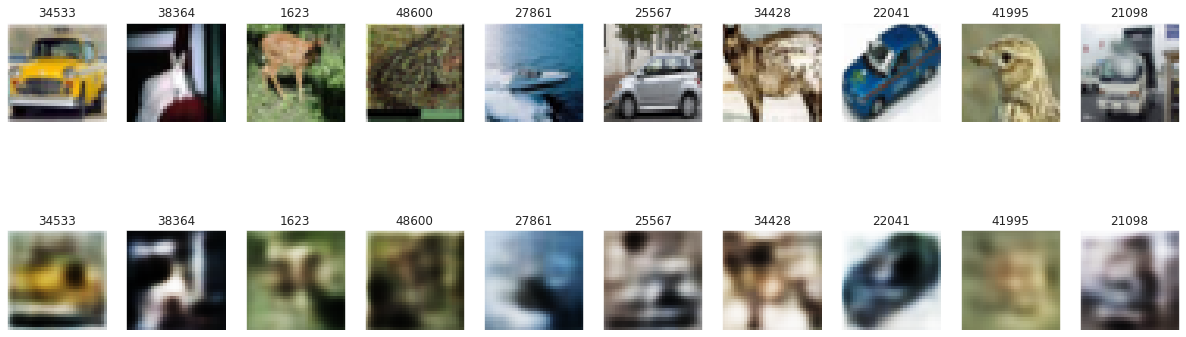

In [ ]:
# Результат на проверочной выборке
plotImages(xTrain, predTrainCifar10Ver2)

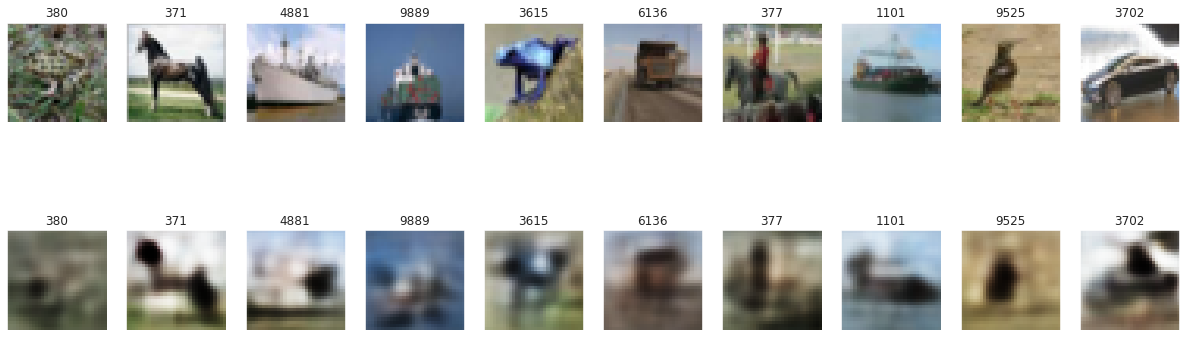

In [ ]:
# Результат на тестовой выборке
plotImages(xTest, predTestCifar10Ver2)

In [ ]:
# Cреднеквадратичная ошибка от правильной картинки и восстановленной (на обучающей и тестовой выборки)
err1 = [getMSE(xTrain[i], predTrainCifar10Ver2[i] / 255) for i in range(len(predTrainCifar10Ver2))]
err2 = [getMSE(xTest[i], predTestCifar10Ver2[i] /255) for i in range(len(predTestCifar10Ver2))]

In [ ]:
print("Средняя ошибка на обучающем наборе: ", sum(err1) / xTrain.shape[0])
print("Средняя ошибка на тестовом наборе: ", sum(err2) / xTest.shape[0])

Средняя ошибка на обучающем наборе:  0.01805359445726886
Средняя ошибка на тестовом наборе:  0.016944318200669547


# MNIST

Результат конечно не идеальный, посмотрим как нейронная сеть справится на зарекомендовавшей себя в плане хороших результатов база Mnist

In [ ]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Сделаем копию обучающей и тестовой выборок и в них будем добавлять черные квадраты на каждой картинке.

xTrainMnist_squareBlack = xTrainMnist.copy()
xTestMnist_squareBlack = xTestMnist.copy()


In [ ]:
# C помощью цикла пройдемся по всем картинкам
for i in range(0, xTrainMnist_squareBlack.shape[0]):
  square_size = np.random.randint(5,9)           # Произвольно зададим границы квадрата от 5х5 до 8х8
  string = np.random.randint(0,20)                # Получим строку в которой будет начинаться квадрат. Так как максимальный размер квадрата может быть 8х8, то строка будет до 20
  columns = np.random.randint(0,20)               # Получим производный столбец

  for j in range(square_size+1):                  # C помощью цикла будет рисоваться квадрат (приравниваться к 0) на каждой тестовой картинке
    xTrainMnist_squareBlack[i][string+j][columns: columns+square_size] = 0


In [ ]:
# Аналогично для тестовой выборки

for i in range(0, xTestMnist_squareBlack.shape[0]):
  square_size = np.random.randint(5,9)           
  string = np.random.randint(0,20)               
  columns = np.random.randint(0,20)              

  for j in range(square_size+1):                 
    xTestMnist_squareBlack[i][string+j][columns: columns+square_size] = 0

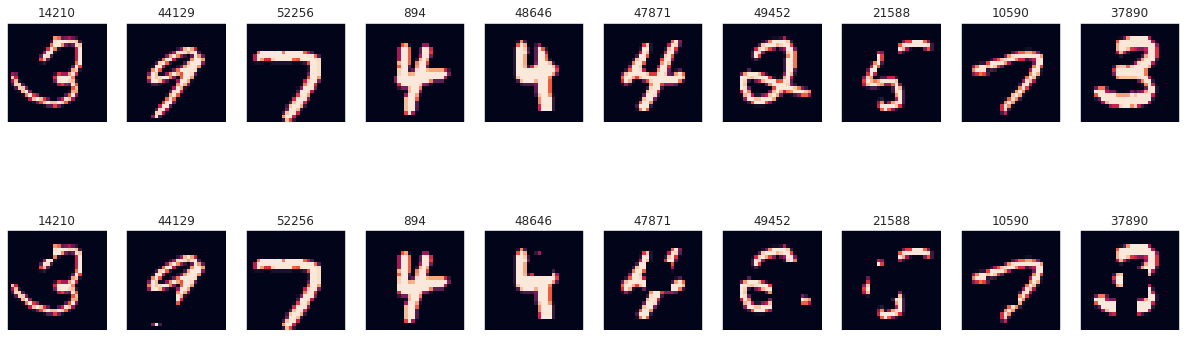

In [ ]:
# Посмотрим на результат.
# C помощью функции выведем изначальные картинки и картинки с произволдными черными квадратами
plotImages(xTrainMnist, xTrainMnist_squareBlack)

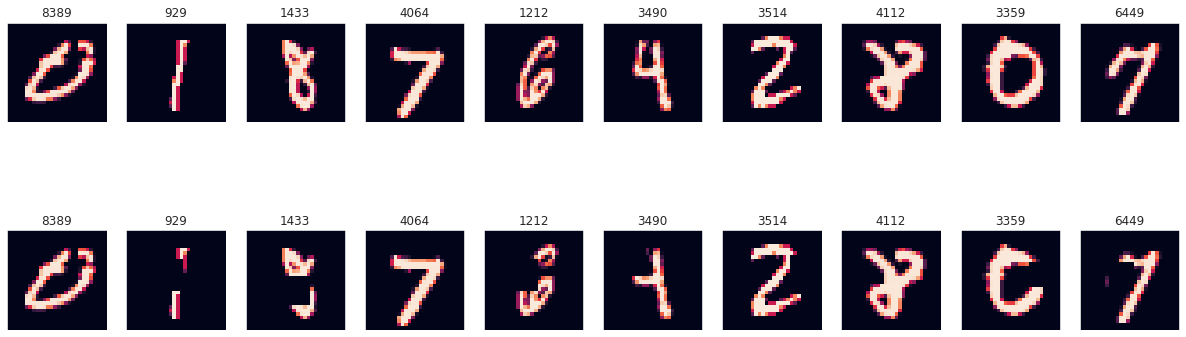

In [ ]:
# Тестовая выборка
plotImages(xTestMnist, xTestMnist_squareBlack)

## Нормализация данных

In [ ]:
# Нормализуем данные в виде значений от 0 до 1 и меняем размерность 
xTrainMnist = xTrainMnist.astype('float32') / 255
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1)

# Аналогично делаем для тестовой выборки
xTestMnist = xTestMnist.astype('float32') / 255
xTestMnist = xTestMnist.reshape(-1, 28, 28, 1)

# Нормализуем обучающую выборку с черными квадратами 
xTrainMnist_squareBlack = xTrainMnist_squareBlack.astype('float32') / 255
xTrainMnist_squareBlack = xTrainMnist_squareBlack.reshape(-1, 28, 28, 1)

# Аналогично тестовую выборку с черными квадратами 
xTestMnist_squareBlack = xTestMnist_squareBlack.astype('float32') / 255
xTestMnist_squareBlack = xTestMnist_squareBlack.reshape(-1, 28, 28, 1)


# Обучение 

**Для чистоты эксперименты возьмем те же самые архитектуры нейронных сетей.**

In [ ]:
# Создаем сеть
modelAutoMnist_Ver1 = baseAutoencoder((28,28,1))

## Обучение сети

In [ ]:
history_modelAutoMnist_Ver1= modelAutoMnist_Ver1.fit(xTrainMnist_squareBlack, xTrainMnist, epochs=150, batch_size=256, validation_data=(xTestMnist_squareBlack, xTestMnist), callbacks=[reduce_lr])

Epoch 1/150
235/235 [==============================] - 24s 94ms/step - loss: 0.0731 - val_loss: 0.1018
Epoch 2/150
235/235 [==============================] - 21s 90ms/step - loss: 0.0217 - val_loss: 0.0345
Epoch 3/150
235/235 [==============================] - 21s 90ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 4/150
235/235 [==============================] - 21s 90ms/step - loss: 0.0113 - val_loss: 0.0101
Epoch 5/150
235/235 [==============================] - 21s 90ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 6/150
235/235 [==============================] - 21s 89ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 7/150
235/235 [==============================] - 21s 90ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 8/150
235/235 [==============================] - 21s 89ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 9/150
235/235 [==============================] - 21s 90ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 10/150
235/235 [==============================] - 21s 90ms/step - l

In [ ]:
# Сохраним полученные веса
modelAutoMnist_Ver1.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoMnist_Ver1_Ultra_Pro.h5')

## Проверка результатов

In [ ]:
# Получаем результат на обучающей выборке
predTrainMnist = modelAutoMnist_Ver1.predict(xTrainMnist_squareBlack)
predTrainMnist = predTrainMnist * 255   # Перевод значений от 0 до 255
predTrainMnist = predTrainMnist.astype('uint8')

In [ ]:
# Получаем результат работы на тестовой выборке
predTestMnist = modelAutoMnist_Ver1.predict(xTestMnist_squareBlack)
predTestMnist = predTestMnist * 255
predTestMnist = predTestMnist.astype('uint8')

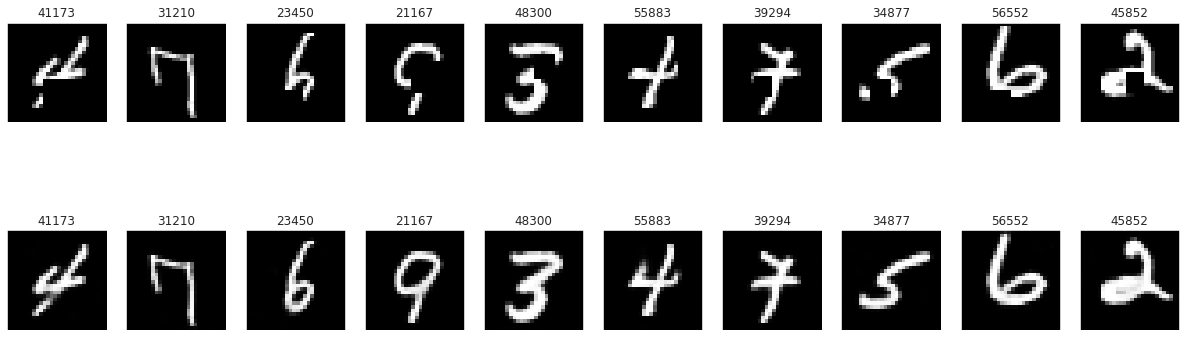

In [ ]:
# Результат на проверочной выборке
plotImagesMnist(xTrainMnist_squareBlack, predTrainMnist, shape=(28,28))

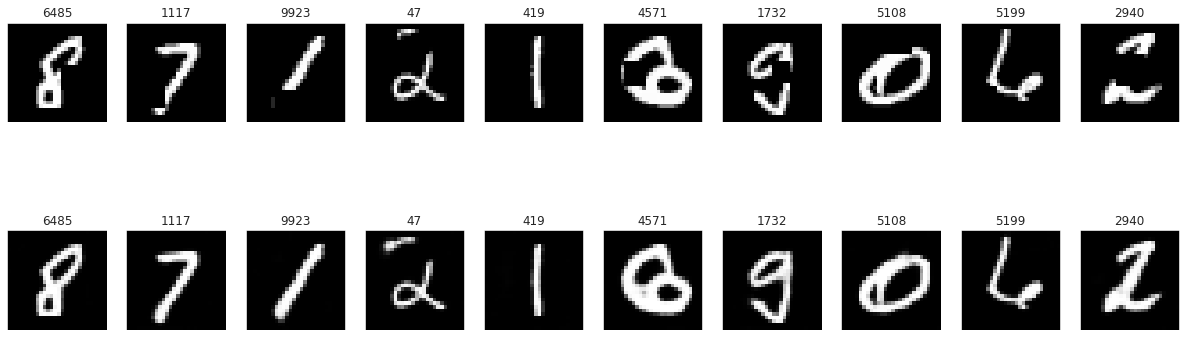

In [ ]:
# Результат на тестовой выборке
plotImagesMnist(xTestMnist_squareBlack, predTestMnist)

In [ ]:
# Cреднеквадратичная ошибка от правильной картинки и восстановленной (на обучающей и тестовой выборки)
err1 = [getMSE(xTrainMnist[i], predTrainMnist[i] / 255) for i in range(len(predTrainMnist))]
err2 = [getMSE(xTestMnist[i], predTestMnist[i] /255) for i in range(len(predTestMnist))]

In [ ]:
print("Средняя ошибка на обучающем наборе: ", sum(err1) / xTrainMnist.shape[0])
print("Средняя ошибка на тестовом наборе: ", sum(err2) / xTestMnist.shape[0])

Средняя ошибка на обучающем наборе:  0.000828465450458667
Средняя ошибка на тестовом наборе:  0.0008628515643148431


# Mnist -  Conv2D - Ver2

In [ ]:
# Создаем сеть
modelAutoMnist_Ver2 = modelAutoencoderConv2DMnist()

## Обучение сети

In [ ]:
history_modelAutoMnist_Ver2 = modelAutoMnist_Ver2.fit(xTrainMnist_squareBlack, xTrainMnist, epochs=50, batch_size=512, validation_data=(xTestMnist_squareBlack, xTestMnist), callbacks=[reduce_lr])

Epoch 1/50
118/118 [==============================] - 50s 395ms/step - loss: 0.0601 - val_loss: 0.0228
Epoch 2/50
118/118 [==============================] - 45s 380ms/step - loss: 0.0172 - val_loss: 0.0134
Epoch 3/50
118/118 [==============================] - 45s 380ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 4/50
118/118 [==============================] - 45s 380ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/50
118/118 [==============================] - 45s 378ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 6/50
118/118 [==============================] - 45s 378ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 7/50
118/118 [==============================] - 45s 378ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 8/50
118/118 [==============================] - 45s 378ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 9/50
118/118 [==============================] - 45s 378ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 10/50
118/118 [==============================] - 45s 378ms/step - l

In [ ]:
# Сохраним полученные веса
modelAutoMnist_Ver2.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoMnist_Ver2_Ultra_Pro.h5')

## Проверка результатов

In [ ]:
# Для загрузки весов
# modelAutoMnist_Ver2.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/modelAutoMnist_Ver2_Ultra_Pro.h5')

In [ ]:
# Получаем результат на обучающей выборке
predTrainMnistVer2 = modelAutoMnist_Ver2.predict(xTrainMnist_squareBlack)
predTrainMnistVer2 = predTrainMnistVer2 * 255   # Перевод значений от 0 до 255
predTrainMnistVer2 = predTrainMnistVer2.astype('uint8')

In [ ]:
# Получаем результат работы на тестовой выборке
predTestMnistVer2 = modelAutoMnist_Ver2.predict(xTestMnist_squareBlack)
predTestMnistVer2 = predTestMnistVer2 * 255
predTestMnistVer2 = predTestMnistVer2.astype('uint8')

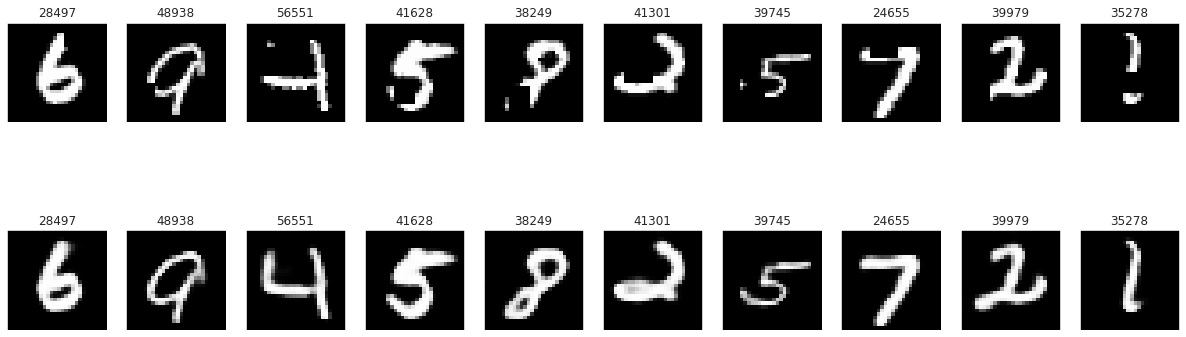

In [ ]:
# Результат на проверочной выборке
plotImagesMnist(xTrainMnist_squareBlack, predTrainMnistVer2, shape=(28,28))

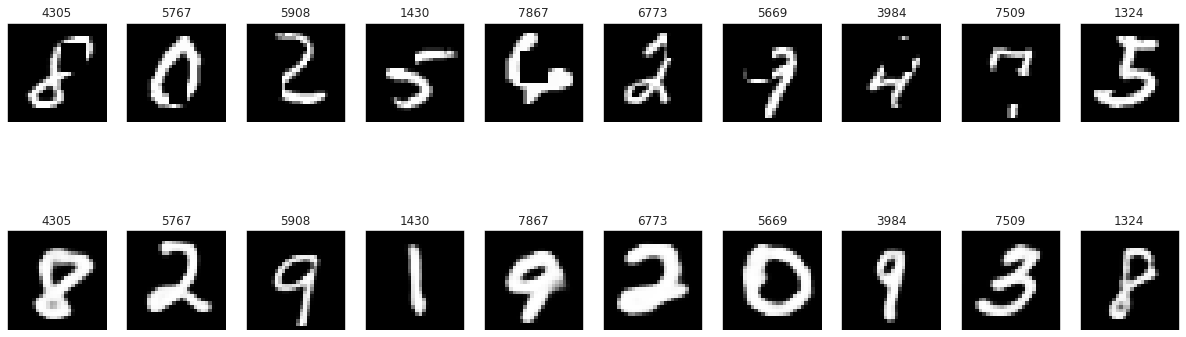

In [ ]:
# Результат на тестовой выборке
plotImagesMnist(xTrainMnist_squareBlack, predTestMnistVer2)

In [ ]:
# Cреднеквадратичная ошибка от правильной картинки и восстановленной (на обучающей и тестовой выборки)
err1 = [getMSE(xTrainMnist_squareBlack[i], predTrainMnistVer2[i] / 255) for i in range(len(predTrainMnistVer2))]
err2 = [getMSE(xTestMnist_squareBlack[i], predTestMnistVer2[i] /255) for i in range(len(predTestMnistVer2))]

In [ ]:
print("Средняя ошибка на обучающем наборе: ", sum(err1) / xTrainMnist_squareBlack.shape[0])
print("Средняя ошибка на тестовом наборе: ", sum(err2) / xTestMnist_squareBlack.shape[0])

Средняя ошибка на обучающем наборе:  0.012854274928839384
Средняя ошибка на тестовом наборе:  0.013405113791654745


# Выводы

1. Данная домашняя работа показала что применяя автокодировщики можно решать поставленную задачу.
2. Результат не идеален. 
3. В зависимости от разной архитектуры сети получается разный результат. Поэтому нужно использовать для достижения наилучшего результата разные архитектуры нейронной сети. Так же не забывать о гиперпараметрах. 
4. Для базы **Mnist** результат вышел намного лучш в отличии от базы **Cifar10**
5. Так же данный эксперимент показывает что изображения с тремя каналами(цветные) автокодировщик восстанавливает хуже чем одноканальные изображения. 
6. Результат работы нейронной сети так же хорошо отпределять не визуаильно, а в с помощью **среднеквадратичной ошибки** применяя соответствующие функции. 
7. Данная серия домашних работ показала как могут автокодировщики применяться на практике. 